In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [2]:
def factor_function(sigma_i, sigma_j, permutation):
    final = 1
    total = 0
    
    if sigma_i == 1:
        total = sigma_j + np.sum(permutation)
        
        if total == 0:
            final *= 1
        else:
            return 0
        
    return final

In [3]:
def BP(d, mu=0, tol=1e-12, max_iter=10000, damping_parameter=0.5, verbose=0, init_psi=None):
    psi=np.zeros((2,2))
    if init_psi is None:
        psi=np.random.uniform(size=(2,2))
        psi=psi/np.sum(psi)
    else:
        psi=init_psi.copy()
    
    permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
    
    for t in range(max_iter):
        psi_new=np.zeros((2,2))
        for i in range(2):
            for j in range(2):
                for perm in permutations:
                    mult=1
                    if factor_function(i, j, perm)==0:
                        continue
                    for k in perm:
                        mult*=psi[k,i]
                    psi_new[i,j]+=np.exp(mu*i)*mult
                    
        if np.sum(psi_new)!=0:
            psi_new=psi_new/np.sum(psi_new)
        else:
            psi_new=np.array([[0.25, 0.25],[0.25, 0.25]])
        
        psi_new=damping_parameter*psi+(1-damping_parameter)*psi_new
        
        Delta=np.linalg.norm(psi_new-psi)
        if verbose==2 and t%100==0:
            print("Iter : ", t+1, " Delta : ", Delta)
        psi=psi_new
        if Delta<tol:
            break
    
    if t==max_iter-1:
        print("No convergence"+" ! Final error: "+ str(Delta))
    else:
        if verbose>=1:
            print("Converged ! Number of iteration "+str(t))
    
    return psi

In [109]:
BP_fixed_point_test=BP(3, mu=0, verbose=1)
print("Fixed point : \n", BP_fixed_point_test)

Converged ! Number of iteration 37
Fixed point : 
 [[4.05585524e-01 4.05585524e-01]
 [1.88828952e-01 5.24084474e-13]]


In [4]:
def update_observables(psi, mu, d):
        phi_=0
        phi__=0
        permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
        numerator=0
        for i in range(2):
            for j in range(2):
                for perm in permutations:
                    if factor_function(i, j, perm)==0:
                        continue
                    mult=psi[j,i]
                    for k in perm:
                        mult*=psi[k,i]
                    phi_+=np.exp(mu*i)*mult
                    numerator+=i*np.exp(mu*i)*mult
                phi__+=psi[i,j]*psi[j,i]

        if phi_==0:
            phi_=1e-16
        if phi__==0:
            phi__=1e-16
        phi=np.log(phi_)-d/2*np.log(phi__)

        if numerator==0:
            rho=0
        else:
            rho=numerator/phi_
            
        s=phi-mu*rho

        return phi, rho, s

##to confirm at the end
def density_numerical(phi_list, mu_list):
    N=phi_list.size
    rho=np.zeros(N-1)
    for i in range(N-1):
        rho[i]=(phi_list[i+1]-phi_list[i])/(mu_list[i+1]-mu_list[i])
    return rho

In [5]:
mu_space = np.linspace(-6, 12, 200)
d = 3
phi_list = []
rho_list = []
s_list = []
for mu in mu_space:
    psi = BP(d, mu=mu, verbose=0)
    phi, rho, s = update_observables(psi, mu, d)
    phi_list.append(phi)
    rho_list.append(rho)
    s_list.append(s)

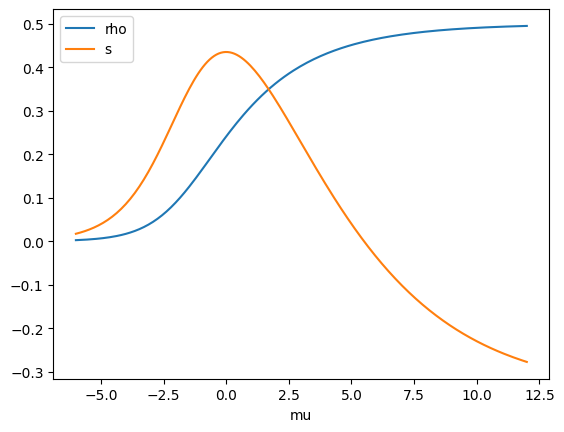

In [6]:
plt.plot(mu_space, rho_list, label='rho')
plt.plot(mu_space, s_list, label='s')
plt.xlabel('mu')
plt.legend()
plt.show()

In [7]:
def find_zero_bisection(arr):
    # Function to find zero using bisection method
    left = 0
    right = len(arr) - 1
    if(arr[left]*arr[right] > 0):
        print("No zero crossing found")
        return -1

    while right - left > 1:
        mid = (left + right) // 2
        if arr[mid] == 0:
            return mid  # Zero found at index 'mid'
        elif arr[mid] * arr[left] < 0:
            right = mid
        else:
            left = mid

    # If exact zero not found, return the index closest to zero
    return left if abs(arr[left]) < abs(arr[right]) else right

In [8]:
print(find_zero_bisection(s_list))

127


In [9]:
def complete_run(d, mu_space, verbose=0, max_iter=100000, damping_parameter=0.8):
    phi_list = []
    rho_list = []
    s_list = []
    for mu in mu_space:
        psi = BP(d, mu=mu, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        phi, rho, s = update_observables(psi, mu, d)
        phi_list.append(phi)
        rho_list.append(rho)
        s_list.append(s)

    zero_index = find_zero_bisection(s_list)
    if zero_index == -1:
        return -1
    return rho_list[zero_index]

In [20]:
d_list = [3, 4, 5]
densest_packings = {}
mu_space = np.linspace(2, 10, 500)
for d in tqdm(d_list):
    densest_packings[d] = complete_run(d, mu_space)

100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


In [21]:
print(densest_packings)

{3: 0.45898965645869283, 4: 0.42052909551769263, 5: 0.38867356136833214}


Linear Stability

In [10]:
import sympy as sp

In [84]:
psi_00 = sp.symbols('psi_00', real=True)
psi_01 = sp.symbols('psi_01', real=True)
psi_10 = sp.symbols('psi_10', real=True)
psi_11 = sp.symbols('psi_11', real=True)

psi_test = sp.Matrix([[psi_00, psi_01], [psi_10, psi_11]])

mu_test = sp.symbols('mu', real=True)

def bp_update_equation(d, psi, mu):
    permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
    psi_new = sp.zeros(2, 2)
    for i in range(2):
        for j in range(2):
            for perm in permutations:
                mult = 1
                if factor_function(i, j, perm) == 0:
                    continue
                for k in perm:
                    mult *= psi[k, i]
                psi_new[i, j] += sp.exp(mu*i)*mult
    
    sum_elements = sp.Add(*psi_new)
    psi_new = psi_new/sum_elements
    return psi_new

psi_new_test = bp_update_equation(3, psi_test, mu_test)
psi_new_test = psi_new_test.reshape(4, 1)
psi_vec = psi_test.reshape(4, 1)

jacobian_top = psi_new_test.jacobian(psi_vec)
eigenvalues = jacobian_top.eigenvals()

mu = 28.3 
BP_fixed_point_test = BP(d=3, mu=mu, verbose=0)
numerical_values = {psi_00: BP_fixed_point_test[0, 0], psi_01: BP_fixed_point_test[0, 1], psi_10: BP_fixed_point_test[1, 0], psi_11: BP_fixed_point_test[1, 1], mu_test: mu}
numerical_eigenvalues = [e.evalf(subs=numerical_values) for e in eigenvalues]


In [85]:
bp_update_equation(3, psi_test, mu_test)

Matrix([
[(psi_00**2 + 2*psi_00*psi_10 + psi_10**2)/(2*psi_00**2 + 4*psi_00*psi_10 + psi_01**2*exp(mu) + 2*psi_10**2), (psi_00**2 + 2*psi_00*psi_10 + psi_10**2)/(2*psi_00**2 + 4*psi_00*psi_10 + psi_01**2*exp(mu) + 2*psi_10**2)],
[                        psi_01**2*exp(mu)/(2*psi_00**2 + 4*psi_00*psi_10 + psi_01**2*exp(mu) + 2*psi_10**2),                                                                                                           0]])

In [67]:
print(BP_fixed_point_test)
print(numerical_eigenvalues)
print(eigenvalues)

[[8.00035125e-05 8.00035130e-05]
 [9.99839993e-01 6.03050065e-13]]
[-2.00016001065325, 0]
{2*psi_01**2*(-2*psi_00**3 - psi_00**2*psi_01*exp(mu) - 6*psi_00**2*psi_10 + psi_00*psi_01**2*exp(mu) - 2*psi_00*psi_01*psi_10*exp(mu) - 6*psi_00*psi_10**2 + psi_01**2*psi_10*exp(mu) - psi_01*psi_10**2*exp(mu) - 2*psi_10**3)*exp(mu)/(2*psi_00**4 + 8*psi_00**3*psi_10 + 12*psi_00**2*psi_10**2 + 8*psi_00*psi_10**3 + psi_01**4*exp(2*mu) + 2*psi_10**4)**(3/2): 1, 0: 3}


In [86]:
def bp_update_equation(d, psi, mu):
    permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
    psi_new = sp.zeros(2, 2)
    for i in range(2):
        for j in range(2):
            for perm in permutations:
                mult = 1
                if factor_function(i, j, perm) == 0:
                    continue
                for k in perm:
                    mult *= psi[k, i]
                psi_new[i, j] += sp.exp(mu*i)*mult
    sum_elements = sp.Add(*psi_new)
    psi_new = psi_new/sum_elements
    return psi_new

def BP_jacobian_max_eigenvalue(d, psi_fixed_point, mu_num):
    psi_00 = sp.symbols('psi_00', real=True)
    psi_01 = sp.symbols('psi_01', real=True)
    psi_10 = sp.symbols('psi_10', real=True)
    psi_11 = sp.symbols('psi_11', real=True)
    psi = sp.Matrix([[psi_00, psi_01], [psi_10, psi_11]])
    mu = sp.symbols('mu', real=True)
    psi_new = bp_update_equation(d, psi, mu)

    psi_new = psi_new.reshape(4, 1)
    psi_vec = psi.reshape(4, 1)
    
    jacobian_result = psi_new.jacobian(psi_vec)

    numerical_values = {psi_00: psi_fixed_point[0,0], psi_01: psi_fixed_point[0,1], psi_10: psi_fixed_point[1,0], psi_11: psi_fixed_point[1,1], mu: mu_num}

    eigenvalues = jacobian_result.eigenvals()

    numerical_eigenvalues = [e.evalf(subs=numerical_values) for e in eigenvalues]

    largest_eigenvalue = max(np.abs(numerical_eigenvalues))
    
    return largest_eigenvalue
    

In [101]:
def linear_stability_analysis(d, mu_space, verbose=0, max_iter=100000, damping_parameter=0.8):
    stability_parameters = []
    rho_list = []
    for mu in tqdm(mu_space):
        BP_fixed_point = BP(d, mu=mu, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        largest_eigenvalue = BP_jacobian_max_eigenvalue(d, BP_fixed_point, mu)
        c_tilde = 1/(d-1)
        stability_parameters.append(largest_eigenvalue**2*c_tilde-1)
        phi, rho, s = update_observables(BP_fixed_point, mu, d)
        rho_list.append(rho)

    zero_index = find_zero_bisection(stability_parameters)
    if zero_index == -1:
        return -1, -1, stability_parameters
    return mu_space[zero_index], rho_list[zero_index], stability_parameters
    

In [102]:
mu_space = np.linspace(2, 10, 50)
stability_mu, stability_densest_packing, stability_params = linear_stability_analysis(3, mu_space)

100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


In [103]:
print(stability_mu)
print(stability_densest_packing)
print(stability_params)

3.3061224489795915
0.4132918089257219
[-0.342308241912053, -0.299582770624420, -0.256845600389180, -0.214243192909587, -0.171910682829122, -0.129971501241002, -0.0885372456893698, -0.0477077562479747, -0.00757136016621185, 0.0317947492911343, 0.0703240304397672, 0.107960034007229, 0.144655790548124, 0.180373164152899, 0.215082188869023, 0.248760401626659, 0.281392182501611, 0.312968111012434, 0.343484345237649, 0.372942028712656, 0.401346728501679, 0.428707907049818, 0.455038428944863, 0.480354103076745, 0.504673260311597, 0.528016365746836, 0.550405664696435, 0.571864860988085, 0.592418826032529, 0.612093337022444, 0.630914842369848, 0.648910252734464, 0.666106755625197, 0.682531651930291, 0.698212212548001, 0.713175553471809, 0.727448527598009, 0.741057631960644, 0.754028928704097, 0.766387978560986, 0.778159785611464, 0.789368752091279, 0.800038642086254, 0.810192553437397, 0.819852896468783, 0.829041379199309, 0.837778997867214, 0.846086032380266, 0.853982045866937, 0.8614858878840

In [106]:
def complete_run_stability(verbose=0, max_iter=10000, damping_parameter=0.8):
    mu_space = np.linspace(2, 6, 400)
    d_list = [3, 4, 5, 6, 7, 8, 9, 10]
    stability_densest_packing_list = []
    mu_stability_list = []
    for d in d_list:
        stability_mu, stability_densest_packing, stability_params = linear_stability_analysis(d, mu_space, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        stability_densest_packing_list.append(stability_densest_packing)
        mu_stability_list.append(stability_mu)
        print("d = ", d, "mu = ", stability_mu, "rho = ", stability_densest_packing)

    return mu_stability_list, stability_densest_packing_list

In [107]:
mu_stability_list, stability_densest_packing_list = complete_run_stability()

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [02:15<00:00,  2.95it/s]


d =  3 mu =  3.333333333333333 rho =  0.4140976600967152


100%|██████████| 400/400 [03:09<00:00,  2.12it/s]


d =  4 mu =  2.8922305764411025 rho =  0.3659065529602715


100%|██████████| 400/400 [03:58<00:00,  1.68it/s]


d =  5 mu =  2.7719298245614032 rho =  0.3333089279289404


100%|██████████| 400/400 [04:48<00:00,  1.38it/s]


d =  6 mu =  2.7518796992481205 rho =  0.3090132393298793


100%|██████████| 400/400 [05:44<00:00,  1.16it/s]


d =  7 mu =  2.7719298245614032 rho =  0.28972598827828266


100%|██████████| 400/400 [52:32<00:00,  7.88s/it]    


d =  8 mu =  2.8220551378446115 rho =  0.2741881270928912


100%|██████████| 400/400 [09:43<00:00,  1.46s/it]


d =  9 mu =  2.882205513784461 rho =  0.26105864128472434


100%|██████████| 400/400 [1:37:26<00:00, 14.62s/it]    

d =  10 mu =  2.9523809523809526 rho =  0.2498856663652508


In [ ]:
print(mu_stability_list)
print(stability_densest_packing_list)


[3.3467336683417086, 2.9045226130653266, 2.7638190954773867, 2.7437185929648242]
[0.00017134881201939578, 2.0047828877251167e-06, 3.1704722823432315e-08, 5.656619357907435e-10]
